In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt

### Define Hyperparameters

In [2]:
batch_size = 4
n_classes = 5

### Define Graph

In [3]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [4]:
def scale_and_shift_flat(x, labels, reuse=True):
    with tf.variable_scope("scale_and_shift", reuse=reuse):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])
        
        class_shift = tf.gather(beta, labels)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        class_shift = tf.expand_dims(class_shift, 1)
        print(f'class_shift shape: {class_shift.get_shape().as_list()}')
        
        class_scale = tf.gather(gamma, labels)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        class_scale = tf.expand_dims(class_scale, 1)
        print(f'class_scale shape: {class_scale.get_shape().as_list()}')
        
        print(f'Prior x shape: {x.get_shape().as_list()}')
        output = x + class_shift
        print(f'output int1 shape: {output.get_shape().as_list()}')
        output *= class_scale
        print(f'output final shape: {output.get_shape().as_list()}\n')
        return output

In [5]:
def scale_and_shift(x, labels, reuse=True):
    with tf.variable_scope("scale_and_shift", reuse=reuse):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        print(f'x shape: {x_shape}')
        beta = tf.get_variable( 'beta', [n_classes])# ,
                                     # initializer=tf.zeros_initializer())
        print(f'beta shape: {beta.get_shape().as_list()}')
        gamma = tf.get_variable( 'gamma', [n_classes])#,
                                    # initializer=tf.ones_initializer())
        print(f'gamma shape: {gamma.get_shape().as_list()}')
        
        conditioned_shift = tf.gather(beta, labels)
        print(f'conditioned_shift shape: {conditioned_shift.get_shape().as_list()}')
        conditioned_shift = tf.expand_dims(tf.expand_dims(tf.expand_dims(conditioned_shift, 1), 1), 1)
        print(f'conditioned_shift shape: {conditioned_shift.get_shape().as_list()}')
        
        conditioned_scale = tf.gather(gamma, labels)
        print(f'conditioned_scale shape: {conditioned_scale.get_shape().as_list()}')
        conditioned_scale = tf.expand_dims(tf.expand_dims(tf.expand_dims(conditioned_scale, 1), 1), 1)
        print(f'conditioned_scale shape: {conditioned_scale.get_shape().as_list()}')
        
        output = x + conditioned_shift
        output *= conditioned_scale
        
#         mean, variance = tf.nn.moments(x, axis, keep_dims=True)
#         print(f'mean shape: {mean.get_shape().as_list()}')
#         print(f'variance shape: {variance.get_shape().as_list()}')
        
#         moments_shape = tf.shape(mean)
#         mu = tf.zeros(moments_shape)
#         sigma = tf.ones(moments_shape)
#         print(f'mu shape: {mu.get_shape().as_list()}')
#         print(f'sigma shape: {sigma.get_shape().as_list()}')
        
#         variance_epsilon = 0.01
# #         output = tf.nn.batch_normalization(x=x, mean=conditioned_shift,
# #                                            variance=conditioned_scale,
# #                                            offset=None, scale=None,
# #                                            variance_epsilon=variance_epsilon)
#         output = tf.nn.batch_normalization(x=x, mean=mu,
#                                            variance=sigma,
#                                            offset=conditioned_shift, scale=conditioned_scale,
#                                            variance_epsilon=variance_epsilon)
#         print(f'output shape: {output.get_shape().as_list()}')
        return output

    

In [6]:
def encoder(X_in, labels, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 210, 160, 3])
        
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f'x shape: {tf.shape(x)}')
        x = scale_and_shift(x, labels, reuse=False)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, reuse=True)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        print(f'final x: {x.get_shape().as_list()}')
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

In [10]:
def decoder(sampled_z, labels, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(f'First x shape: {x.get_shape().as_list()}')
        x = scale_and_shift_flat(x, labels, reuse=False)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.dense(x, units=(inputs_decoder * 2 + 1), activation=lrelu)
        x = scale_and_shift_flat(x, labels, reuse=True)
        x = tf.reshape(x, reshaped_dim)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        x = tf.nn.dropout(x, keep_prob)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        x = tf.nn.dropout(x, keep_prob)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels)
        print(f'x shape: {x.get_shape().as_list()}')
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=210*160*3, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 210, 160, 3])
        return img

### Initialize Graph

In [11]:
tf.reset_default_graph()

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 210, 160, 3], name='X')
Labels = tf.placeholder(dtype=tf.int32, shape=[None], name='Labels')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 210, 160, 3], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 210*160*3])
print(f'Y_flat: {Y_flat.get_shape().as_list()}')
print(f'Labels: {Labels.get_shape().as_list()}')
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

X_test = tf.constant(1, dtype=tf.float32, shape=[batch_size, 210, 160, 3], name='const_x_test')
Labels_test = tf.constant(0, dtype=tf.int32, shape=[batch_size], name='Labels_test')
Y_test = tf.constant(1, dtype=tf.float32, shape=[batch_size, 210, 160, 3], name='const_x_test')
Y_flat_test = tf.reshape(Y, shape=[-1, 210*160*3])
keep_prob_test = tf.constant(0.8, dtype=tf.float32, shape=(), name='keep_prob_test')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

# sampled, mn, sd = encoder(X_in, Labels, keep_prob)
sampled, mn, sd = encoder(X_test, Labels_test, keep_prob_test)
# dec = decoder(sampled, keep_prob)
dec = decoder(sampled, Labels_test, keep_prob_test)
print(f'dec: {dec.get_shape().as_list()}')

unreshaped = tf.reshape(dec, [-1, 210*160*3])
print(f'unreshaped: {unreshaped.get_shape().as_list()}')
# img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat_test), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)

# introduce variable learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Y_flat: [None, 100800]
Labels: [None]
x shape: Tensor("encoder/Shape:0", shape=(4,), dtype=int32)
x shape: [4, 105, 80, 64]
beta shape: [5]
gamma shape: [5]
conditioned_shift shape: [4]
conditioned_shift shape: [4, 1, 1, 1]
conditioned_scale shape: [4]
conditioned_scale shape: [4, 1, 1, 1]
x shape: [4, 53, 40, 64]
beta shape: [5]
gamma shape: [5]
conditioned_shift shape: [4]
conditioned_shift shape: [4, 1, 1, 1]
conditioned_scale shape: [4]
conditioned_scale shape: [4, 1, 1, 1]
final x: [4, 135680]
First x shape: [4, 24]
class_shift shape: [4]
class_shift shape: [4, 1]
class_scale shape: [4]
class_scale shape: [4, 1]
Prior x shape: [4, 24]
output int1 shape: [4, 24]
output final shape: [4, 24]

x shape: [4, 24]
class_shift shape: [4]
class_shift shape: [4, 1]
class_scale shape: [4]
class_scale shape: [4, 1]
Prior x shape: [4, 49]
output int1 shape: [4, 49]
output final shape: [4, 49]

x shape: [4, 7, 7, 1]
x shape: [4, 14, 14, 64]
beta shape: [5]
gamma shape: [5]
conditioned_shift shap

In [ ]:
print('creating session...')
sess = tf.Session()
print('initializing variables...')
sess.run(tf.global_variables_initializer())
print('Session created. Variables initialized.')

creating session...
initializing variables...


### Gather New Training Data

In [4]:
directories = ['jamesbond', 'spaceinvaders', 'tutankham', 'venture', 'zaxxon']
state_label_pairs = []
for i, root_dir in enumerate(directories):
    for dir_name, subdir_list, file_list in os.walk(root_dir+'/'):
        for fname in file_list:
            state_label_pairs.append((root_dir + '/' + fname, i))

print(f'Found {len(state_label_pairs)} files.')

Found 500 files.


### Train Model

In [5]:
def read_image(filename):
    image = np.load(filename)
    print(image.shape)
    plt.imshow(image)
    plt.show()

(210, 160, 3)


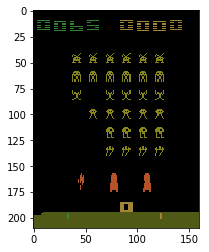

(210, 160, 3)


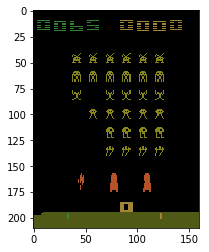

(210, 160, 3)


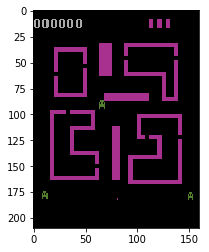

(210, 160, 3)


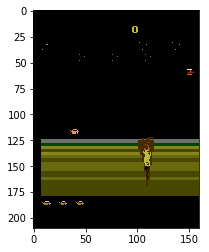

In [6]:
for i in range(1):
    next_batch = random.sample(state_label_pairs, batch_size)
    batch = [read_image(b[0]) for b in next_batch]
    labels = [lab[1] for lab in next_batch]
#     sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
        
#     if not i % 200:
#         ls, d, i_ls, mu, sigm = sess.run([loss, dec, img_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
#         plt.imshow(np.reshape(read_image(next_batch[0][0]), [210, 160, 3]), cmap='gray')
#         plt.show()
#         plt.imshow(d[0], cmap='gray')
#         plt.show()
#         print(i, ls, np.mean(i_ls))

### Sample New Images

In [ ]:
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
classes = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [210, 160, 3]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')